# Human Activity Recognition Using Smartphones Dataset

Jorge L. Reyes-Ortiz(1,2), Davide Anguita(1), Alessandro Ghio(1), Luca Oneto(1) and Xavier Parra(2)
1 - Smartlab - Non-Linear Complex Systems Laboratory
DITEN - Università  degli Studi di Genova, Genoa (I-16145), Italy. 
2 - CETpD - Technical Research Centre for Dependency Care and Autonomous Living
Universitat Politècnica de Catalunya (BarcelonaTech). Vilanova i la Geltrú (08800), Spain
activityrecognition '@' smartlab.ws 


The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data. 

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain. See 'features_info.txt' for more details. 

For each record it is provided:
======================================

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 
- An identifier of the subject who carried out the experiment.

License:
========
Use of this dataset in publications must be acknowledged by referencing the following publication [1] 

[1] Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013. 

This dataset is distributed AS-IS and no responsibility implied or explicit can be addressed to the authors or their institutions for its use or misuse. Any commercial use is prohibited.



### Importing Important Libraries

In [249]:
# !pip install -q torchmetrics -U mlxtend

In [250]:
import torch
from torch import nn
from pathlib import Path
import random
import os
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from timeit import default_timer as timer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


### Setting up the Device

In [251]:
torch.cuda.is_available()

True

In [252]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


### Getting some Data

In [253]:
sensor_data_path = Path(r'F:\Python_Projects\Learning\Neural_Networks\data\human+activity+recognition+using+smartphones\UCI HAR Dataset\UCI HAR Dataset')

In [254]:
txt_list = list(sensor_data_path.glob('*/*.txt'))
txt_list

[WindowsPath('F:/Python_Projects/Learning/Neural_Networks/data/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/subject_test.txt'),
 WindowsPath('F:/Python_Projects/Learning/Neural_Networks/data/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt'),
 WindowsPath('F:/Python_Projects/Learning/Neural_Networks/data/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt'),
 WindowsPath('F:/Python_Projects/Learning/Neural_Networks/data/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/subject_train.txt'),
 WindowsPath('F:/Python_Projects/Learning/Neural_Networks/data/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt'),
 WindowsPath('F:/Python_Projects/Learning/Neural_Networks/data/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt')]

In [255]:
x_train = pd.read_csv(sensor_data_path / 'train' / 'X_train.txt', delim_whitespace=True, header=None)
y_train = pd.read_csv(sensor_data_path / 'train' / 'y_train.txt', delim_whitespace=True, header=None)
x_test = pd.read_csv(sensor_data_path / 'test' / 'X_test.txt', delim_whitespace=True, header=None)
y_test = pd.read_csv(sensor_data_path / 'test' / 'y_test.txt', delim_whitespace=True, header=None)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

C:\Users\SUBHO\AppData\Local\Temp\ipykernel_37872\1007515285.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  x_train = pd.read_csv(sensor_data_path / 'train' / 'X_train.txt', delim_whitespace=True, header=None)
C:\Users\SUBHO\AppData\Local\Temp\ipykernel_37872\1007515285.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_train = pd.read_csv(sensor_data_path / 'train' / 'y_train.txt', delim_whitespace=True, header=None)
C:\Users\SUBHO\AppData\Local\Temp\ipykernel_37872\1007515285.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  x_test = pd.read_csv(sensor_data_path / 'test' / 'X_test.txt', delim_whitespace=True, header=None)
C:\Users\SUBHO\AppData\Local\Temp\ipykernel_37872\1007515285.py:

((7352, 561), (7352, 1), (2947, 561), (2947, 1))

### Creating a Custom "Dataset"

In [256]:
class Sensor_Dataset(Dataset):
    def __init__(self, target_dir):
        target_dir = Path(target_dir)

        scaler = StandardScaler()

        x_file = next(target_dir.glob("X*.txt"))
        y_file = next(target_dir.glob("y*.txt"))

        # load once (pandas -> numpy)
        x_np = pd.read_csv(x_file, delim_whitespace=True, header=None).to_numpy(dtype=np.float32)
        y_np = pd.read_csv(y_file, delim_whitespace=True, header=None).to_numpy(dtype=np.int64)

        # ensure shapes & contiguity
        y_np = y_np.reshape(-1)        # (N,1) -> (N,)
        x_np = np.ascontiguousarray(x_np)
        y_np = np.ascontiguousarray(y_np)
        x_np = scaler.fit_transform(x_np)

        # convert to tensors (CPU)
        self.x_data = torch.from_numpy(x_np)        # dtype=torch.float32
        self.y_data = torch.from_numpy(y_np)        # dtype=torch.int64

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [257]:
train_dir = sensor_data_path / 'train'
test_dir = sensor_data_path / 'test'

In [258]:
train_data = Sensor_Dataset(train_dir)
test_data = Sensor_Dataset(test_dir)

C:\Users\SUBHO\AppData\Local\Temp\ipykernel_37872\420188455.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  x_np = pd.read_csv(x_file, delim_whitespace=True, header=None).to_numpy(dtype=np.float32)
C:\Users\SUBHO\AppData\Local\Temp\ipykernel_37872\420188455.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_np = pd.read_csv(y_file, delim_whitespace=True, header=None).to_numpy(dtype=np.int64)
C:\Users\SUBHO\AppData\Local\Temp\ipykernel_37872\420188455.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  x_np = pd.read_csv(x_file, delim_whitespace=True, header=None).to_numpy(dtype=np.float32)
C:\Users\SUBHO\AppData\Local\Temp\ipykernel_37872\420188455.py:12: FutureWarning: The 'delim_whites

In [259]:
train_data, test_data

(<__main__.Sensor_Dataset at 0x20a6a3dfa50>,
 <__main__.Sensor_Dataset at 0x20a6fb16bd0>)

### Dividing the Data into batches using DataLoader

In [260]:
train_dataloader = DataLoader(train_data, batch_size=32, num_workers=0,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, num_workers=0,shuffle=False)

In [261]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x20a6fb3e010>,
 <torch.utils.data.dataloader.DataLoader at 0x20a6fb0dc90>)

### Creating the Model

In [262]:
class Sequence_Identifier(nn.Module):
    def __init__(self,
                 input_shape: int,
                 cnn_hidden: int,
                 rnn_hidden: int,
                 rnn_layer: int,
                 output_shape:int):
        super().__init__()
        self.dropout = nn.Dropout(p=0.45)
        self.conv_block_1 = nn.Sequential(
            nn.Conv1d(in_channels=input_shape,
                      out_channels=cnn_hidden*2,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=cnn_hidden*2,
                      out_channels=cnn_hidden,
                      kernel_size=3,
                      stride = 1,
                      padding =1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,
                         stride=1))
        self.rnn = nn.GRU(
            input_size = cnn_hidden,
            hidden_size = rnn_hidden,
            batch_first = True,
            num_layers= rnn_layer,
            bidirectional= True,
            dropout= 0.3)
        self.fc = nn.Linear(rnn_hidden *2, output_shape)

    def forward(self,x):
        x = x.unsqueeze(1) #Conv1d expects (batch, channels, length)
        x = self.conv_block_1(x)
        x = self.dropout(x)
        
        x = x.permute(0,2,1 )   # (batch, new_len, cnn_hidden)
        out, _ = self.rnn(x)
        out = self.dropout(out)
        out = out[:,-1,:]       # Use last time step
        out = self.fc(out)      # [batch, num_classes]
        return out

### Creating training and testing loop functions

In [263]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: str = 'cpu'):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for batch, (x,y) in enumerate(dataloader):
        x,y = x.to(device) , y.to(device)
        y = y-1
        y= y.long()
        

        y_pred = model(x)
        
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        # print(f'Value predicted on training data {y_pred_class}')
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = (train_acc / len(dataloader))

    return train_loss, train_acc

In [264]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              device: str = 'cpu'):
    y_found = []
    model.eval()
    test_loss = 0.0
    test_acc = 0.0

    with torch.inference_mode():
        for batch, (x,y) in enumerate(dataloader):
            x,y = x.to(device), y.to(device)
            y = y-1
            y = y.long()
            
            y_pred = model(x)
            

            loss = loss_fn(y_pred,y)
            test_loss += loss.item()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            # print(f'Value predicted on testing data {y_pred_class}')
            test_acc += (y_pred_class == y).sum().item() / len(y_pred)
            y_found.append(y_pred_class)

    test_loss = test_loss / len(dataloader)
    test_acc = (test_acc / len(dataloader))
    return test_loss, test_acc,y_found

### Creating a train function to combine train_step() and test-step()

In [265]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int =5,
          device= device):
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "y_preds": []
    }
    for epoch in tqdm(range(epochs), desc="Training Epochs"):

        train_loss, train_acc = train_step(model = model,
                                           dataloader = train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer = optimizer,
                                           device= device)
        
        test_loss, test_acc, y_preds = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        print(f' Epoch: {epoch+1}/{epochs},\n'
              f"Train loss: {train_loss:.4f}, Train acc: {train_acc*100:.4f}\n"
              f"Test loss: {test_loss:.4f}, Test acc: {test_acc*100:.4f}")
        
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
        results['y_preds'] = y_preds

    return results


### Training and Evaluating Model

In [266]:
torch.cuda.manual_seed(36)

NUM_EPOCHS = 50

model = Sequence_Identifier(
    input_shape = 1,
    cnn_hidden = 64,
    rnn_hidden = 64,
    rnn_layer = 2,
    output_shape = 6    
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, weight_decay=1e-2)

start_time = timer()

model_results = train(model = model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      loss_fn=loss_fn,
                      optimizer=optimizer,
                      epochs=NUM_EPOCHS,
                      device='cuda')

end_time = timer()

total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training Epochs:   2%|▏         | 1/50 [00:04<03:55,  4.80s/it]

 Epoch: 1/50,
Train loss: 0.9192, Train acc: 61.0326
Test loss: 0.6267, Test acc: 70.3741


Training Epochs:   4%|▍         | 2/50 [00:09<03:40,  4.60s/it]

 Epoch: 2/50,
Train loss: 0.5737, Train acc: 73.6957
Test loss: 0.5995, Test acc: 71.9870


Training Epochs:   6%|▌         | 3/50 [00:13<03:32,  4.51s/it]

 Epoch: 3/50,
Train loss: 0.5514, Train acc: 75.4348
Test loss: 0.5961, Test acc: 71.9534


Training Epochs:   8%|▊         | 4/50 [00:18<03:25,  4.48s/it]

 Epoch: 4/50,
Train loss: 0.5258, Train acc: 76.4900
Test loss: 0.5895, Test acc: 73.2415


Training Epochs:  10%|█         | 5/50 [00:22<03:20,  4.45s/it]

 Epoch: 5/50,
Train loss: 0.5217, Train acc: 76.9475
Test loss: 0.5744, Test acc: 74.5968


Training Epochs:  12%|█▏        | 6/50 [00:26<03:15,  4.44s/it]

 Epoch: 6/50,
Train loss: 0.5086, Train acc: 77.0969
Test loss: 0.5807, Test acc: 74.6304


Training Epochs:  14%|█▍        | 7/50 [00:31<03:10,  4.43s/it]

 Epoch: 7/50,
Train loss: 0.5032, Train acc: 78.1250
Test loss: 0.5523, Test acc: 75.4256


Training Epochs:  16%|█▌        | 8/50 [00:35<03:06,  4.43s/it]

 Epoch: 8/50,
Train loss: 0.5039, Train acc: 77.7446
Test loss: 0.6064, Test acc: 69.7581


Training Epochs:  18%|█▊        | 9/50 [00:40<03:01,  4.43s/it]

 Epoch: 9/50,
Train loss: 0.4907, Train acc: 79.0217
Test loss: 0.5491, Test acc: 74.4624


Training Epochs:  20%|██        | 10/50 [00:44<02:57,  4.44s/it]

 Epoch: 10/50,
Train loss: 0.4999, Train acc: 78.4013
Test loss: 0.5356, Test acc: 77.3185


Training Epochs:  22%|██▏       | 11/50 [00:49<02:52,  4.44s/it]

 Epoch: 11/50,
Train loss: 0.4770, Train acc: 79.7871
Test loss: 0.5468, Test acc: 76.8817


Training Epochs:  24%|██▍       | 12/50 [00:53<02:48,  4.43s/it]

 Epoch: 12/50,
Train loss: 0.4636, Train acc: 80.6386
Test loss: 0.5421, Test acc: 76.2769


Training Epochs:  26%|██▌       | 13/50 [00:57<02:44,  4.44s/it]

 Epoch: 13/50,
Train loss: 0.4549, Train acc: 81.5806
Test loss: 0.5421, Test acc: 77.5538


Training Epochs:  28%|██▊       | 14/50 [01:02<02:39,  4.44s/it]

 Epoch: 14/50,
Train loss: 0.4642, Train acc: 80.8967
Test loss: 0.5263, Test acc: 77.7218


Training Epochs:  30%|███       | 15/50 [01:06<02:36,  4.46s/it]

 Epoch: 15/50,
Train loss: 0.4399, Train acc: 81.9973
Test loss: 0.5655, Test acc: 76.0417


Training Epochs:  32%|███▏      | 16/50 [01:11<02:31,  4.46s/it]

 Epoch: 16/50,
Train loss: 0.4375, Train acc: 82.6087
Test loss: 0.5234, Test acc: 79.0771


Training Epochs:  34%|███▍      | 17/50 [01:15<02:27,  4.47s/it]

 Epoch: 17/50,
Train loss: 0.4393, Train acc: 81.8116
Test loss: 0.6044, Test acc: 74.6976


Training Epochs:  36%|███▌      | 18/50 [01:20<02:23,  4.48s/it]

 Epoch: 18/50,
Train loss: 0.4369, Train acc: 82.4819
Test loss: 0.4916, Test acc: 79.7267


Training Epochs:  38%|███▊      | 19/50 [01:24<02:18,  4.48s/it]

 Epoch: 19/50,
Train loss: 0.4189, Train acc: 82.7944
Test loss: 0.5326, Test acc: 77.5090


Training Epochs:  40%|████      | 20/50 [01:29<02:14,  4.48s/it]

 Epoch: 20/50,
Train loss: 0.4113, Train acc: 83.5870
Test loss: 0.5125, Test acc: 78.5618


Training Epochs:  42%|████▏     | 21/50 [01:33<02:09,  4.46s/it]

 Epoch: 21/50,
Train loss: 0.4057, Train acc: 84.1350
Test loss: 0.5077, Test acc: 79.4579


Training Epochs:  44%|████▍     | 22/50 [01:38<02:04,  4.46s/it]

 Epoch: 22/50,
Train loss: 0.4126, Train acc: 83.9447
Test loss: 0.5225, Test acc: 78.5842


Training Epochs:  46%|████▌     | 23/50 [01:42<02:00,  4.45s/it]

 Epoch: 23/50,
Train loss: 0.3908, Train acc: 84.6966
Test loss: 0.5327, Test acc: 78.9203


Training Epochs:  48%|████▊     | 24/50 [01:47<01:55,  4.45s/it]

 Epoch: 24/50,
Train loss: 0.4064, Train acc: 84.1078
Test loss: 0.5305, Test acc: 77.9234


Training Epochs:  50%|█████     | 25/50 [01:51<01:51,  4.47s/it]

 Epoch: 25/50,
Train loss: 0.3977, Train acc: 84.4067
Test loss: 0.5865, Test acc: 78.3042


Training Epochs:  52%|█████▏    | 26/50 [01:56<01:48,  4.50s/it]

 Epoch: 26/50,
Train loss: 0.4271, Train acc: 83.6594
Test loss: 0.5291, Test acc: 78.2594


Training Epochs:  54%|█████▍    | 27/50 [02:00<01:43,  4.51s/it]

 Epoch: 27/50,
Train loss: 0.3934, Train acc: 84.5063
Test loss: 0.5644, Test acc: 76.2097


Training Epochs:  56%|█████▌    | 28/50 [02:05<01:39,  4.52s/it]

 Epoch: 28/50,
Train loss: 0.3940, Train acc: 84.1259
Test loss: 0.5339, Test acc: 77.5874


Training Epochs:  58%|█████▊    | 29/50 [02:09<01:34,  4.51s/it]

 Epoch: 29/50,
Train loss: 0.3864, Train acc: 84.8370
Test loss: 0.5153, Test acc: 78.9315


Training Epochs:  60%|██████    | 30/50 [02:14<01:30,  4.51s/it]

 Epoch: 30/50,
Train loss: 0.3989, Train acc: 83.9176
Test loss: 0.5546, Test acc: 76.9489


Training Epochs:  62%|██████▏   | 31/50 [02:18<01:25,  4.52s/it]

 Epoch: 31/50,
Train loss: 0.3950, Train acc: 84.4837
Test loss: 0.5185, Test acc: 78.7522


Training Epochs:  64%|██████▍   | 32/50 [02:23<01:21,  4.53s/it]

 Epoch: 32/50,
Train loss: 0.3955, Train acc: 84.1757
Test loss: 0.5345, Test acc: 78.2258


Training Epochs:  66%|██████▌   | 33/50 [02:27<01:16,  4.53s/it]

 Epoch: 33/50,
Train loss: 0.3906, Train acc: 84.6830
Test loss: 0.5665, Test acc: 77.6098


Training Epochs:  68%|██████▊   | 34/50 [02:32<01:12,  4.51s/it]

 Epoch: 34/50,
Train loss: 0.3844, Train acc: 84.7464
Test loss: 0.5460, Test acc: 77.3522


Training Epochs:  70%|███████   | 35/50 [02:36<01:07,  4.49s/it]

 Epoch: 35/50,
Train loss: 0.3816, Train acc: 85.2264
Test loss: 0.5006, Test acc: 78.9987


Training Epochs:  72%|███████▏  | 36/50 [02:41<01:02,  4.47s/it]

 Epoch: 36/50,
Train loss: 0.3923, Train acc: 84.7781
Test loss: 0.5149, Test acc: 78.4946


Training Epochs:  74%|███████▍  | 37/50 [02:45<00:57,  4.46s/it]

 Epoch: 37/50,
Train loss: 0.3811, Train acc: 85.2355
Test loss: 0.5113, Test acc: 78.9315


Training Epochs:  76%|███████▌  | 38/50 [02:50<00:53,  4.45s/it]

 Epoch: 38/50,
Train loss: 0.3685, Train acc: 85.1359
Test loss: 0.5606, Test acc: 77.4194


Training Epochs:  78%|███████▊  | 39/50 [02:54<00:48,  4.44s/it]

 Epoch: 39/50,
Train loss: 0.3858, Train acc: 84.7101
Test loss: 0.4895, Test acc: 79.8947


Training Epochs:  80%|████████  | 40/50 [02:58<00:44,  4.44s/it]

 Epoch: 40/50,
Train loss: 0.3850, Train acc: 85.0136
Test loss: 0.5415, Test acc: 77.5538


Training Epochs:  82%|████████▏ | 41/50 [03:03<00:39,  4.43s/it]

 Epoch: 41/50,
Train loss: 0.3791, Train acc: 84.6332
Test loss: 0.5090, Test acc: 79.3683


Training Epochs:  84%|████████▍ | 42/50 [03:07<00:35,  4.43s/it]

 Epoch: 42/50,
Train loss: 0.3805, Train acc: 84.7917
Test loss: 0.5241, Test acc: 77.7890


Training Epochs:  86%|████████▌ | 43/50 [03:12<00:30,  4.42s/it]

 Epoch: 43/50,
Train loss: 0.3804, Train acc: 85.3034
Test loss: 0.5255, Test acc: 79.1667


Training Epochs:  88%|████████▊ | 44/50 [03:16<00:26,  4.42s/it]

 Epoch: 44/50,
Train loss: 0.3816, Train acc: 85.3442
Test loss: 0.5469, Test acc: 78.1586


Training Epochs:  90%|█████████ | 45/50 [03:20<00:22,  4.42s/it]

 Epoch: 45/50,
Train loss: 0.3811, Train acc: 85.1042
Test loss: 0.5246, Test acc: 78.9315


Training Epochs:  92%|█████████▏| 46/50 [03:25<00:17,  4.45s/it]

 Epoch: 46/50,
Train loss: 0.3679, Train acc: 85.5797
Test loss: 0.4996, Test acc: 79.9955


Training Epochs:  94%|█████████▍| 47/50 [03:30<00:13,  4.48s/it]

 Epoch: 47/50,
Train loss: 0.3775, Train acc: 85.1087
Test loss: 0.5220, Test acc: 78.2930


Training Epochs:  96%|█████████▌| 48/50 [03:34<00:09,  4.51s/it]

 Epoch: 48/50,
Train loss: 0.3691, Train acc: 85.4257
Test loss: 0.5249, Test acc: 78.5282


Training Epochs:  98%|█████████▊| 49/50 [03:39<00:04,  4.52s/it]

 Epoch: 49/50,
Train loss: 0.3799, Train acc: 85.0679
Test loss: 0.5108, Test acc: 78.9315


Training Epochs: 100%|██████████| 50/50 [03:43<00:00,  4.47s/it]

 Epoch: 50/50,
Train loss: 0.3817, Train acc: 85.1630
Test loss: 0.4983, Test acc: 79.5027
Total training time: 223.68 seconds


### Creating function to plot loss curves

In [267]:
def plot_loss_curves(results: dict[str,list[float]]):
    plt.figure(figsize = (10,7))
    plt.subplot(1,2,1)
    plt.plot(results["train_acc"], label = "Train Accuracy")
    plt.plot(results["test_acc"], label = "Test Accuracy")
    plt.title("Accuracy Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(results["train_loss"], label= "Train Loss")
    plt.plot(results["test_loss"], label= "Test Loss")
    plt.title("Loss Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

### Visualizing the results while training and testing

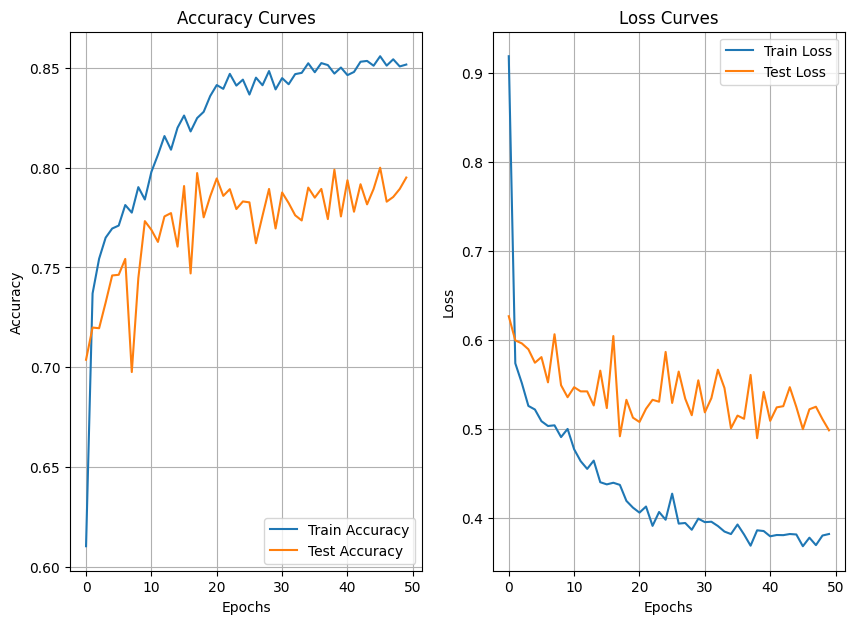

In [268]:
plot_loss_curves(model_results)

### Saving and Loading the Model

In [269]:
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents = True,
                 exist_ok=True)
MODEL_NAME = 'Sensor_Data_predictor.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Saving the model's parameters to the desired location
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj = model.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to: models\Sensor_Data_predictor.pth


In [271]:
# Loading the Model
torch.manual_seed(42)
model_loaded = Sequence_Identifier(
    input_shape = 1,
    cnn_hidden = 64,
    rnn_hidden = 64,
    rnn_layer = 2,
    output_shape = 6    
).to(device)

print(f'Loading Model from: {MODEL_SAVE_PATH}')
model_loaded.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

model_loaded.to(device)

Loading Model from: models\Sensor_Data_predictor.pth


C:\Users\SUBHO\AppData\Local\Temp\ipykernel_37872\1371786587.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_loaded.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

Sequence_Identifier(
  (dropout): Dropout(p=0.45, inplace=False)
  (conv_block_1): Sequential(
    (0): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (rnn): GRU(64, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)